Lab 3: Super Component Direction Determination, Based on Substations

In [1]:
import numpy as np
import seaborn as sns
import networkx as nx
import random
from shapely.geometry import Polygon, LineString, Point
from helpers.border import find_closed_regions
from collections import defaultdict, deque
import matplotlib.pyplot as plt

In [2]:
from helpers.DataLoader import DataLoader

dataloader = DataLoader()

In [3]:
from helpers.policy import policy_helper_power_line_same_direction

direct_sync_dict = policy_helper_power_line_same_direction(dataloader.lines_to_station_pairs)

In [4]:
whether_lines_to_edges = {key: False for key in dataloader.direct_station_pairs_to_line.keys()}
registered_lines_number = 0
edges = []  # The local_edges used for illustration, Edge (x,y) represent a flow from x to y

In [5]:
def get_substation_total_generation(substation):
    current_generation = 0
    for generator in dataloader.substations_to_generators[substation]:
            current_generation += dataloader.generators_to_capacities[generator]
    return current_generation

remove_fixed_edges = set()
for sub1, sub2 in dataloader.direct_station_pairs_to_line.keys():
    if dataloader.substations_to_voltage[sub1] > dataloader.substations_to_voltage[sub2] and (
            dataloader.substations_to_voltage[sub1] != 500):
        remove_fixed_edges.add((sub1, sub2))
    if dataloader.substations_to_voltage[sub1] < dataloader.substations_to_voltage[sub2] and (
            dataloader.substations_to_voltage[sub2] != 500):
        remove_fixed_edges.add((sub2, sub1))
    if dataloader.substations_to_voltage[sub1] == dataloader.substations_to_voltage[sub2]:
        if sub1 in dataloader.substations_to_generators and sub2 in dataloader.substations_to_generators:
            # graph[sub1].add(sub2)
            # graph[sub2].add(sub1)
            pass
        elif sub1 in dataloader.substations_to_generators and get_substation_total_generation(sub1) > 0:
            remove_fixed_edges.add((sub1, sub2))
        elif sub2 in dataloader.substations_to_generators and get_substation_total_generation(sub2) > 0:
            remove_fixed_edges.add((sub2, sub1))
        else:
            # graph[sub1].add(sub2)
            # graph[sub2].add(sub1)
            pass

In [6]:
def get_subgraphs(graph_edges, remove_fixed_edges):
    G = nx.Graph()

    G.add_edges_from(graph_edges)

    G.remove_edges_from(remove_fixed_edges)

    subgraphs = [list(comp) for comp in nx.connected_components(G)]

    return subgraphs


subgraphs = get_subgraphs(dataloader.direct_station_pairs_to_line.keys(), remove_fixed_edges)


In [7]:
def get_subgraphs_with_io(graph_edges, remove_fixed_edges):
    G = nx.Graph()
    G.add_edges_from(graph_edges)

    G.remove_edges_from(remove_fixed_edges)

    subgraphs = [list(comp) for comp in nx.connected_components(G)]

    subgraph_info = []

    for subgraph in subgraphs:
        input_nodes = set()
        output_nodes = set()

        for src, dst in remove_fixed_edges:
            if src in subgraph and dst not in subgraph:
                output_nodes.add(src)
            if dst in subgraph and src not in subgraph:
                input_nodes.add(dst)

        subgraph_info.append({
            "subgraph": subgraph,
            "input_nodes": list(input_nodes),
            "output_nodes": list(output_nodes)
        })

    return subgraph_info


subgraph_info = get_subgraphs_with_io(dataloader.direct_station_pairs_to_line.keys(), remove_fixed_edges)

# for idx, subgraph_data in enumerate(subgraph_info):
#     print(f"Subgraph {idx + 1}: {subgraph_data['subgraph']}")
#     print(f"  Input Nodes: {subgraph_data['input_nodes']}")
#     print(f"  Output Nodes: {subgraph_data['output_nodes']}")
#     print()

In [8]:
import networkx as nx


def assign_directions(subgraph_data, original_edges):
    subgraph_nodes = subgraph_data["subgraph"]
    input_nodes = set(subgraph_data["input_nodes"])
    output_nodes = set(subgraph_data["output_nodes"])

    G = nx.Graph()
    G.add_nodes_from(subgraph_nodes)

    for edge in original_edges:
        if edge[0] in subgraph_nodes and edge[1] in subgraph_nodes and (edge[0], edge[1]) not in remove_fixed_edges and (edge[1],edge[0]) not in remove_fixed_edges:
            G.add_edge(edge[0], edge[1])

    DiG = nx.DiGraph()
    DiG.add_nodes_from(subgraph_nodes)

    visited = set()
    queue = list(input_nodes)

    while queue:
        node = queue.pop(0)
        visited.add(node)

        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                # Direction: node -> neighbor
                DiG.add_edge(node, neighbor)
                queue.append(neighbor)

    return DiG


subgraph_info = get_subgraphs_with_io(dataloader.direct_station_pairs_to_line.keys(), remove_fixed_edges)

directed_subgraphs = []
for subgraph_data in subgraph_info:
    directed_graph = assign_directions(subgraph_data, dataloader.undirect_station_pairs_to_line.keys())
    directed_subgraphs.append(directed_graph)


In [9]:
edges = set()
for idx, DiG in enumerate(directed_subgraphs):
    for edge in DiG.edges:
        edges.add(edge)

edges = edges | remove_fixed_edges


In [10]:
special_case_edges = []
for e1, e2 in dataloader.direct_station_pairs_to_line.keys():
    if (e1, e2) not in edges and (e2, e1) not in edges:
        special_case_edges.append((e1, e2))
        print(e1, e2)

for special_edge in special_case_edges:
    edges.add(special_edge)

In [11]:
# Process the local_edges in case there's repeats
edges = list(set(edges))
print(len(edges), len(dataloader.direct_station_pairs_to_line.keys()))

855 855


In [12]:
edges_set = set(edges)
seen = set()

for u, v in edges_set:
    if (v, u) in edges_set:
        key = tuple(sorted((u, v)))
        if key not in seen:
            print(f"Bidirectional duplicate found: {key[0]} ↔ {key[1]}")
            seen.add(key)


In [13]:
# Configuration Dictionary
config = {
    "line": {
        "visible": True,
        "show_names": False,
        "filter_voltage": True,
        "target_voltages": [69, 138, 240, 500]
    },
    "station": {
        "color": "red",
        "edge_color": "black",
        "visible": True,
        "show_names": False
    },
    "city": {
        "color": "yellow",
        "edge_color": "black",
        "visible": False,
        "show_names": False
    },
    "region": {
        "visible": True,
        "show_names": True,
        "colors": ["lightblue", "lightgreen", "lightcoral", "lightsalmon", "lightgray"]
    }

}


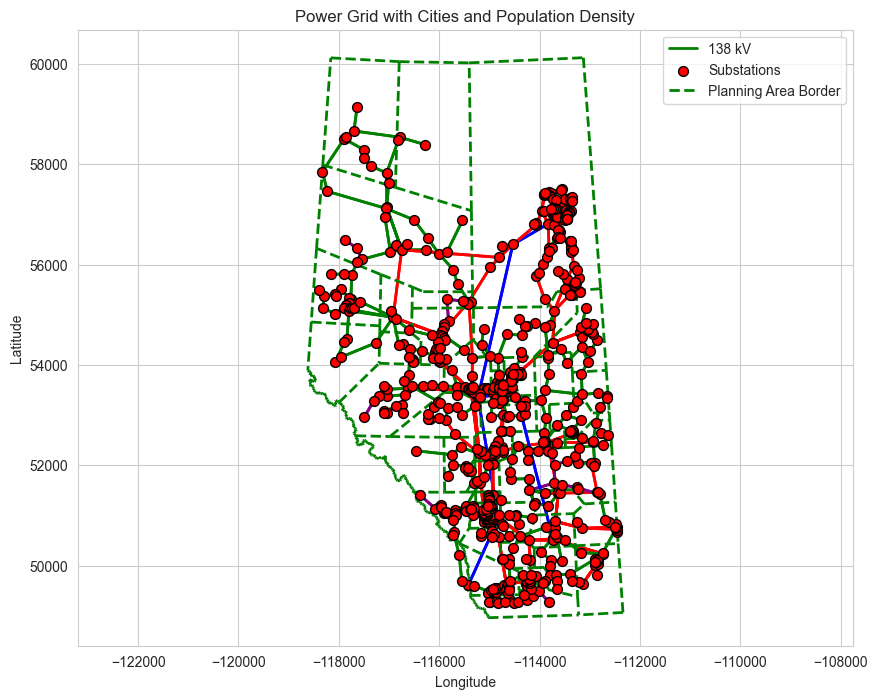

In [14]:
plt.figure(figsize=(10, 8))

# Assuming dataloader is an instance of DataLoader and config is defined
first_line = True
first_border = True

# Plot lines
if config["line"]["visible"]:
    for (station_x, station_y), lines in dataloader.undirect_station_pairs_to_line.items():
        start_coords = dataloader.substations_to_coordinates[station_x]
        end_coords = dataloader.substations_to_coordinates[station_y]

        filtered_lines = [line for line in lines if
                          dataloader.lines_to_voltage[line] in config["line"]["target_voltages"]] if config["line"][
            "filter_voltage"] else lines

        for line in filtered_lines:
            voltage = dataloader.lines_to_voltage[line]
            color = dataloader.voltage_colors.get(voltage, "black")  # Default to black if voltage is not mapped
            plt.plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]], color=color, linewidth=2,
                     label=f"{voltage} kV" if first_line else "")

            if config["line"]["show_names"]:
                mid_x = (start_coords[0] + end_coords[0]) / 2
                mid_y = (start_coords[1] + end_coords[1]) / 2
                plt.text(mid_x, mid_y, f"{line} ({voltage} kV)", fontsize=8, color="black", ha="center")

            first_line = False

# Plot substations
if config["station"]["visible"]:
    x_vals, y_vals = zip(*dataloader.substations_to_coordinates.values())

    plt.scatter(x_vals, y_vals, color=config["station"]["color"], s=50, label="Substations",
                edgecolors=config["station"]["edge_color"], zorder=3)

    if config["station"]["show_names"]:
        for substation, coords in dataloader.substations_to_coordinates.items():
            plt.text(coords[0], coords[1], substation, fontsize=9, ha="right", color="black", zorder=4)

if config['region']["visible"]:
    for start, end in dataloader.planning_area_border_edges:
        plt.plot([start[0], end[0]], [start[1], end[1]],
                 "g--", linewidth=2, label="Planning Area Border" if first_border else "")
        first_border = False

# Plot cities
if config["city"]["visible"]:
    x_vals, y_vals = zip(*dataloader.city_to_coordinates.values())
    plt.scatter(x_vals, y_vals, color=config["city"]["color"], s=80, label="Cities",
                edgecolors=config["city"]["edge_color"], zorder=4)

    if config["city"]["show_names"]:
        for city_name, (x, y) in dataloader.city_to_coordinates.items():
            plt.text(x, y, city_name, fontsize=10, ha="left", color="black", zorder=5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Power Grid with Cities and Population Density")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [15]:
from helpers.position import map_cities_to_planning_areas, map_stations_to_planning_areas, get_substations_in_city_areas

planning_area_closed_regions = find_closed_regions(dataloader.planning_area_border_df)
city_closed_regions = find_closed_regions(dataloader.city_border_df)

planning_area_to_cities = map_cities_to_planning_areas(planning_area_closed_regions, dataloader.city_to_coordinates)

planning_area_to_stations = map_stations_to_planning_areas(planning_area_closed_regions,
                                                           dataloader.substations_to_coordinates)

substations_in_city_areas = get_substations_in_city_areas(city_closed_regions, dataloader.substations_to_coordinates)

planning_area_colors = sns.color_palette("Paired", len(planning_area_closed_regions))
random.shuffle(planning_area_colors)


In [16]:
stations_outside_planning_areas = []

for name, (x, y) in dataloader.substations_to_coordinates.items():
    station_point = Point(x, y)
    in_any_area = False

    for polygon in planning_area_closed_regions:
        if polygon.contains(station_point):
            in_any_area = True
            break

    if not in_any_area:
        stations_outside_planning_areas.append(name)

# Handle exceptions: A few Alberta substations are not in the lands (not covered within any planning areas)
planning_area_to_stations["53"].append('978S')
planning_area_to_stations["53"].append('CRANBROOK B2S')
planning_area_to_stations["53"].append('NATAL')

In [17]:
from helpers.demand import estimate_substation_demand_average_within_planning_area, \
    estimate_substation_demand_average_within_planning_area_urban_check

activate_urban_check = True

year = 2023

if activate_urban_check:
    substation_demand_dict = estimate_substation_demand_average_within_planning_area_urban_check(
        planning_area_to_stations, dataloader.planning_area_demand[year], substations_in_city_areas,
        dataloader.get_city_population_ratio())
else:
    substation_demand_dict = estimate_substation_demand_average_within_planning_area(planning_area_to_stations,
                                                                                     dataloader.planning_area_demand[year])

0.8475058267949285


In [18]:
# Configuration Dictionary
config = {
    "line": {
        "visible": False,
        "show_names": False,
        "filter_voltage": True,
        "target_voltages": [0, 69, 138, 240, 500]
        # "target_voltages": [0, 500]
    },
    "station": {
        "color": "red",
        "edge_color": "black",
        "visible": False,
        "show_names": False
    },
    "city": {
        "color": "yellow",
        "edge_color": "black",
        "visible": False,
        "show_names": False
    },
    "region": {
        "visible": False,
        "show_names": True,
        "colors": ["lightblue", "lightgreen", "lightcoral", "lightsalmon", "lightgray"]
    }
}


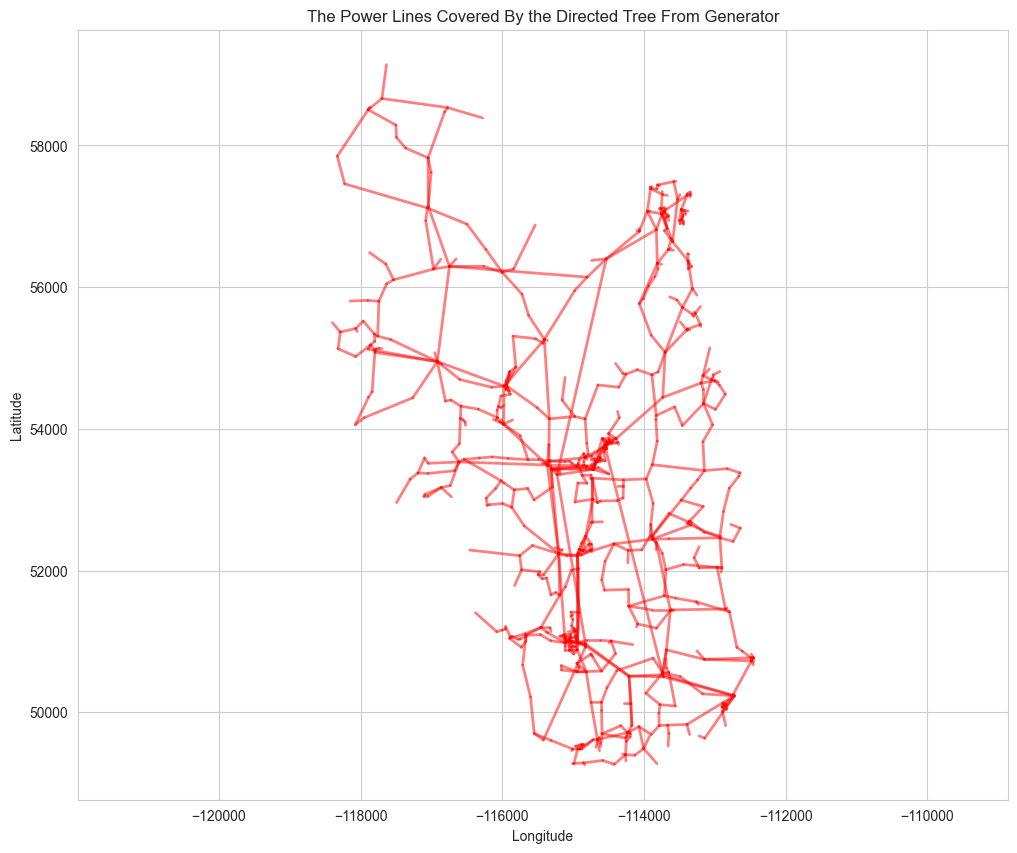

In [19]:
highlight_color = "red"

fig, ax = plt.subplots(figsize=(12, 10))

if config["region"]["visible"]:
    for idx, polygon in enumerate(planning_area_closed_regions):
        x, y = polygon.exterior.xy
        region_name = dataloader.planning_area_gen_area_dict[idx + 1]
        region_color = config["region"]["colors"][idx % len(config["region"]["colors"])]

        ax.fill(x, y, color=region_color, alpha=0.8, label=f"Region {region_name}")
        ax.plot(x, y, 'k-', linewidth=2)


def find_reachable_edges(local_edges, generators_to_substations):
    pfg = nx.DiGraph()
    pfg.add_edges_from(local_edges)

    all_reachable_nodes = set()
    pdf_edges = set(pfg.edges())

    for generator_station in set(generators_to_substations.values()):
        if generator_station in pfg:
            all_reachable_nodes.update(nx.descendants(pfg, generator_station))

    local_reachable_edges = {edge for edge in pdf_edges if
                             edge[0] in all_reachable_nodes or edge[1] in all_reachable_nodes}

    local_unreachable_edges = pdf_edges - local_reachable_edges
    return pdf_edges, local_reachable_edges, local_unreachable_edges


all_edges, reachable_edges, unreachable_edges = find_reachable_edges(edges, dataloader.generators_to_substations)


def find_edges_within_voltage(local_edges, target_voltages):
    result_edges = []
    for edge in local_edges:
        local_lines = dataloader.undirect_station_pairs_to_line[edge]
        local_filtered_lines = (
            [line for line in local_lines if dataloader.lines_to_voltage[line] in target_voltages]
        )

        if local_filtered_lines:
            result_edges.append(edge)

    return result_edges


all_edges = find_edges_within_voltage(all_edges, config["line"]["target_voltages"])
reachable_edges = find_edges_within_voltage(reachable_edges, config["line"]["target_voltages"])
unreachable_edges = find_edges_within_voltage(unreachable_edges, config["line"]["target_voltages"])

plotted_labels = set()
generator_connected_color = "red"
default_station_color = "blue"

for (station_x, station_y) in all_edges:
    if station_x in dataloader.substations_to_coordinates and station_y in dataloader.substations_to_coordinates:
        start_coords = dataloader.substations_to_coordinates[station_x]
        end_coords = dataloader.substations_to_coordinates[station_y]

        if (station_x, station_y) in reachable_edges:
            color = "red"
        else:
            color = "black"

        # Draw the station
        if config["station"]["visible"]:
            for station_name in [station_x, station_y]:
                is_generator_connected = station_name in set(dataloader.generators_to_substations.values())
                station_color = generator_connected_color if is_generator_connected else default_station_color
                label = "Generator-Connected" if is_generator_connected else "Substations"

                coordinates = dataloader.substations_to_coordinates[station_name]

                if label not in plotted_labels:
                    ax.scatter(coordinates[0], coordinates[1], color=station_color, s=50, label=label,
                               edgecolors=config["station"]["edge_color"], zorder=3)
                    plotted_labels.add(label)
                else:
                    ax.scatter(coordinates[0], coordinates[1], color=station_color, s=50,
                               edgecolors=config["station"]["edge_color"], zorder=3)

                if config["station"]["show_names"]:
                    ax.text(coordinates[0], coordinates[1], station_name, fontsize=9, ha="right", color="black",
                            zorder=4)

        ax.plot(
            [start_coords[0], end_coords[0]],
            [start_coords[1], end_coords[1]],
            color=color,
            linewidth=2,
            alpha=0.5
        )

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("The Power Lines Covered By the Directed Tree From Generator")
plt.grid(True)
plt.axis("equal")
plt.show()


In [20]:
# Construct directed graph
power_flow_graph = nx.DiGraph()
power_flow_graph.add_edges_from(edges)  # Add the determined directions

substation_to_load = {s: 0.0 for s in substation_demand_dict.keys()}

# Calculate the power contribution of each generator
for generator, station in dataloader.generators_to_substations.items():
    if station not in power_flow_graph:
        continue

    # The supply from each generator
    generator_capacity = float(dataloader.generators_to_capacities.get(generator, 0))

    # All the reachable substations
    reachable_substations = set(nx.descendants(power_flow_graph, station))
    reachable_substations.add(station)

    # The total demand for reachable substations
    total_demand_index = float(sum(substation_demand_dict.get(s, 0)
                                   for s in reachable_substations))
    if total_demand_index == 0:
        continue

    # Allocate the generation supply to each substations
    for substation in reachable_substations:
        demand_index = float(substation_demand_dict.get(substation, 0))
        load_ratio = demand_index / total_demand_index
        substation_to_load[substation] += load_ratio * generator_capacity

    # subgraph_edges = [(u, v) for u, v in power_flow_graph.local_edges() if u in reachable_substations and v in reachable_substations]
    # subgraph = nx.DiGraph(subgraph_edges)

In [21]:
import cvxpy as cp

nodes = list(set(node for edge in edges for node in edge))
lines = edges

# Initialize generation for all nodes to zero
generation = {node: 0 for node in nodes}

# Accumulate generation capacities for substations that appear in local_edges
for generator, substation in dataloader.generators_to_substations.items():
    if substation in generation:  # Only count substations that appear in local_edges
        capacity = dataloader.generators_to_capacities.get(generator, 0)  # Get generator capacity
        generation[substation] += capacity  # Add capacity to the corresponding substation

# Load consumption at substations
consumption = substation_to_load

# Define variables: power flow on each line (must be non-negative)
F = {line: cp.Variable(nonneg=True) for line in lines}

# Additional slack variable, only allowing positive errors
slack_plus = {i: cp.Variable(nonneg=True) for i in
              nodes}  # Represents positive deviation (only compensates for shortages)

# Generate flow conservation constraints (ensuring left side ≥ 0)
constraints = []
for i in nodes:
    inflow = sum(F[(j, i)] for j, k in lines if k == i)  # Total incoming flow to node i
    outflow = sum(F[(i, j)] for k, j in lines if k == i)  # Total outgoing flow from node i

    # Ensure that inflow + generation is at least equal to outflow + consumption
    constraints.append(inflow + generation[i] - outflow - consumption[i] >= 0)

    # Allow a slack variable (but only positive)
    constraints.append(inflow + generation[i] - outflow - consumption[i] == slack_plus[i])

# Objective function: minimize the sum of slack_plus variables (to reduce imbalance as much as possible)
objective = cp.Minimize(sum(slack_plus[i] for i in nodes))

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Output results
print("Power line flow distribution:")
for line in lines:
    print(f"Line {line}: Load = {F[line].value:.2f}")

print("\nFlow conservation error (Slack):")
for i in nodes:
    print(f"Node {i}: Slack+ = {slack_plus[i].value:.2f}")

# Check solver status
if prob.status == "optimal":
    print("Found the globally optimal solution!")
elif prob.status == "optimal_inaccurate":
    print("Found an approximately optimal solution (potential numerical issues)")
elif prob.status == "infeasible":
    print("The problem is infeasible, check constraints!")
elif prob.status == "unbounded":
    print("The problem is unbounded, check if constraints are properly set!")
else:
    print(f"Solver status unknown: {prob.status}")


Power line flow distribution:
Line ('207S', '228S'): Load = 0.47
Line ('428S', '179S'): Load = 2.35
Line ('254S', '67S'): Load = 12.87
Line ('987S', '71S'): Load = 4.84
Line ('802S', '768S'): Load = 0.22
Line ('419S', '151S'): Load = 14.27
Line ('62S', '68S'): Load = 6.43
Line ('89S', '522S'): Load = 0.25
Line ('478S', '329S'): Load = 0.04
Line ('D05', '848S'): Load = 340.74
Line ('738S', '725S'): Load = 0.20
Line ('103S', '383S'): Load = 0.00
Line ('435S', '504S'): Load = 0.70
Line ('946S', '959S'): Load = 1.38
Line ('216S', '184S'): Load = 0.75
Line ('764S', '843S'): Load = 0.00
Line ('604S', '928S'): Load = 2.52
Line ('732S', '858S'): Load = 0.24
Line ('855S', '853S'): Load = 0.46
Line ('679S', '845S'): Load = 85.39
Line ('28S', '435S'): Load = 0.76
Line ('426S', '101S'): Load = 0.64
Line ('289S', '40S'): Load = 5.29
Line ('377S', '594S'): Load = 0.30
Line ('772S', '776S'): Load = 0.18
Line ('43S', '272S'): Load = 0.78
Line ('959S', '767S'): Load = 0.87
Line ('150S', '191S'): Load =

In [22]:
line_to_load = {line: F[line].value for line in lines}


Flow Conservation Validation Results:
Node 893S: inflow + generation = 1.14, outflow + consumption = 1.14, error = 0.00
Node RIVERVIEW: inflow + generation = 31.29, outflow + consumption = 31.29, error = 0.00
Node SS-43: inflow + generation = 15.04, outflow + consumption = 15.04, error = 0.00
Node 522S: inflow + generation = 0.50, outflow + consumption = 0.50, error = -0.00
Node 2081S: inflow + generation = 23.03, outflow + consumption = 23.03, error = -0.00
Node 2091S: inflow + generation = 74.98, outflow + consumption = 74.98, error = -0.00
Node 650S: inflow + generation = 1.77, outflow + consumption = 1.77, error = 0.00
Node 112S: inflow + generation = 2.02, outflow + consumption = 2.02, error = -0.00
Node 107S: inflow + generation = 18.67, outflow + consumption = 18.67, error = 0.00
Node 874S: inflow + generation = 200.00, outflow + consumption = 200.00, error = 0.00
Node 324S: inflow + generation = 5.48, outflow + consumption = 5.48, error = 0.00
Node 155S: inflow + generation = 

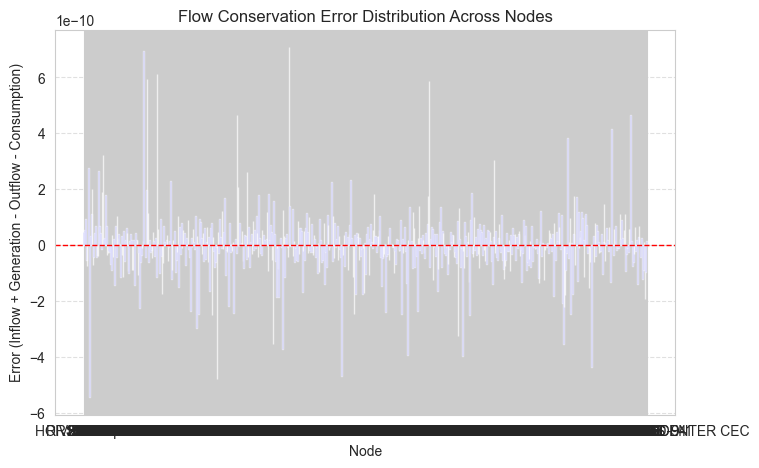

In [23]:
# Initialize validation results
validation_results = {}

# Iterate through all nodes to verify flow conservation
for i in nodes:
    inflow = sum(line_to_load[(j, i)] for j, k in lines if k == i)  # Inflow to node i
    outflow = sum(line_to_load[(i, j)] for k, j in lines if k == i)  # Outflow from node i
    left_side = inflow + generation[i]
    right_side = outflow + consumption[i]

    # Calculate error
    error = left_side - right_side

    # Store in validation dictionary
    validation_results[i] = {
        "inflow": inflow,
        "generation": generation[i],
        "outflow": outflow,
        "consumption": consumption[i],
        "left_side": left_side,
        "right_side": right_side,
        "error": error
    }

# Output validation results
print("\nFlow Conservation Validation Results:")
for node, result in validation_results.items():
    print(
        f"Node {node}: inflow + generation = {result['left_side']:.2f}, outflow + consumption = {result['right_side']:.2f}, error = {result['error']:.2f}")

# If all errors are close to 0, the validation passes
if all(abs(result["error"]) < 1e-6 for result in validation_results.values()):
    print("\nValidation Passed: All nodes satisfy flow conservation!")
else:
    print("\nValidation Failed: Some nodes do not satisfy flow conservation!")

# Extract nodes and error values
nodes_list = list(validation_results.keys())
errors = [validation_results[node]["error"] for node in nodes_list]

# Plot error distribution
plt.figure(figsize=(8, 5))
plt.bar(nodes_list, errors, color='b', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add reference line

plt.xlabel("Node")
plt.ylabel("Error (Inflow + Generation - Outflow - Consumption)")
plt.title("Flow Conservation Error Distribution Across Nodes")
plt.xticks(nodes_list)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [24]:
if 'validation_results' in globals():
    max_error_node = max(validation_results, key=lambda x: abs(validation_results[x]["error"]))
    max_error_value = validation_results[max_error_node]["error"]

    # Pring Max Error
    print(f"Max Error Node {max_error_node}, Error = {max_error_value:.8f}")
else:
    print("Error: validation_results is not defined.")


Max Error Node 850S, Error = 0.00000000


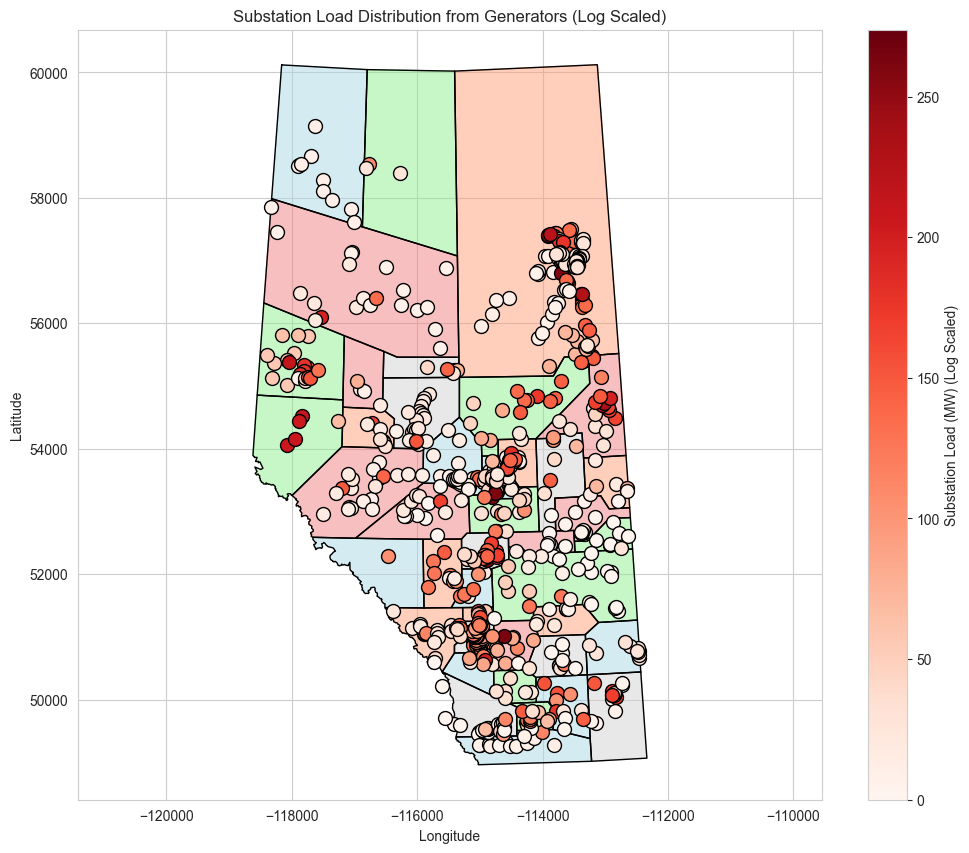

In [25]:
max_load = max(substation_to_load.values()) if substation_to_load else 1

fig, ax = plt.subplots(figsize=(12, 10))

for idx, polygon in enumerate(planning_area_closed_regions):
    x, y = polygon.exterior.xy
    region_color = config["region"]["colors"][idx % len(config["region"]["colors"])]
    ax.fill(x, y, color=region_color, alpha=0.5)
    ax.plot(x, y, 'k-', linewidth=1)

for station_name, (x, y) in dataloader.substations_to_coordinates.items():
    load = substation_to_load.get(station_name, 0)

    normalized_load = np.log1p(load) / np.log1p(max_load)
    color = plt.cm.Reds(normalized_load)

    ax.scatter(x, y, color=color, s=100, edgecolor="black", zorder=3)

sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max_load))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Substation Load (MW) (Log Scaled)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Substation Load Distribution from Generators (Log Scaled)")
plt.grid(True)
plt.axis("equal")
plt.show()

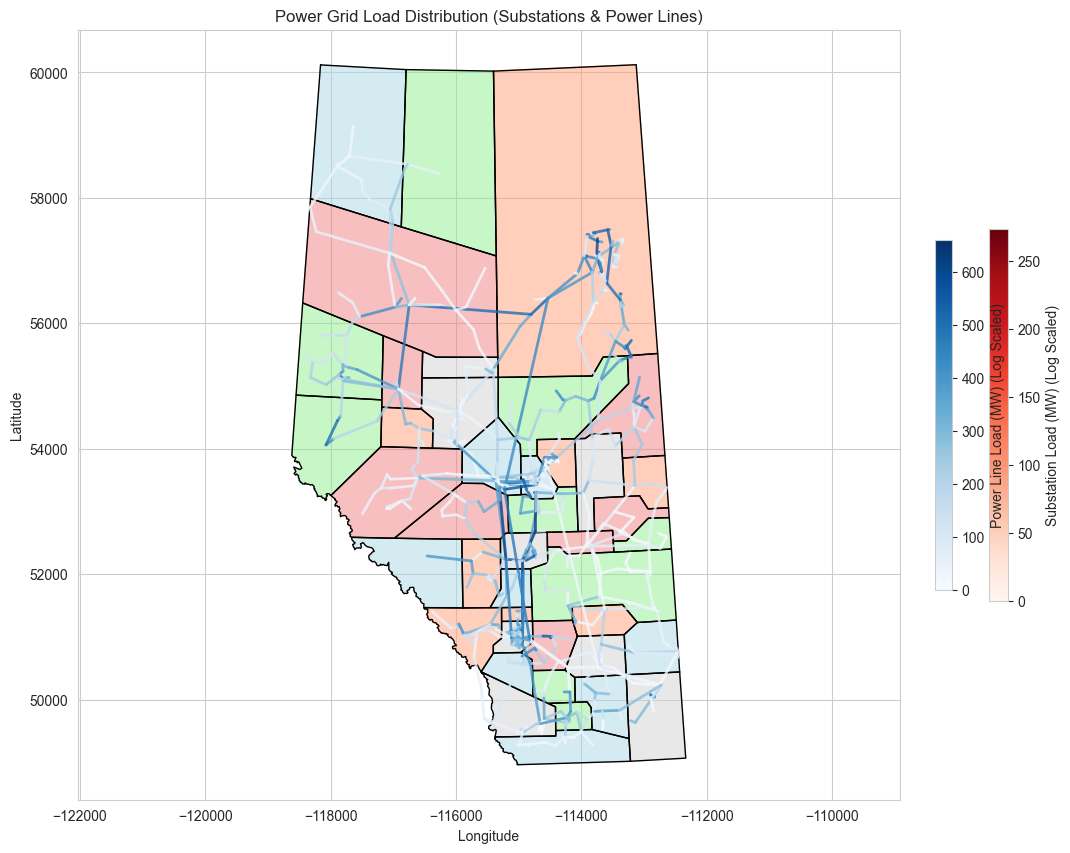

In [26]:
max_line_load = max(line_to_load.values()) if line_to_load else 1

fig, ax = plt.subplots(figsize=(12, 10))

for idx, polygon in enumerate(planning_area_closed_regions):
    x, y = polygon.exterior.xy
    region_color = config["region"]["colors"][idx % len(config["region"]["colors"])]
    ax.fill(x, y, color=region_color, alpha=0.5)
    ax.plot(x, y, 'k-', linewidth=1)

for (station_x, station_y), load in line_to_load.items():
    start_coords = dataloader.substations_to_coordinates.get(station_x)
    end_coords = dataloader.substations_to_coordinates.get(station_y)

    if start_coords and end_coords:
        normalized_load = np.log1p(load) / np.log1p(max_line_load)
        color = plt.cm.Blues(normalized_load)

        ax.plot([start_coords[0], end_coords[0]],
                [start_coords[1], end_coords[1]],
                color=color, linewidth=2, alpha=0.8)

max_station_load = max(substation_to_load.values()) if substation_to_load else 1

sm_stations = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max_station_load))
cbar_stations = plt.colorbar(sm_stations, ax=ax, fraction=0.02, pad=0.04)
cbar_stations.set_label("Substation Load (MW) (Log Scaled)")

sm_lines = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=max_line_load))
cbar_lines = plt.colorbar(sm_lines, ax=ax, fraction=0.02, pad=0.04)
cbar_lines.set_label("Power Line Load (MW) (Log Scaled)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Power Grid Load Distribution (Substations & Power Lines)")
plt.grid(True)
plt.axis("equal")
plt.show()
